In [4]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

# Module 2 - Advanced Classification Methods

### Classification - numerical evaluation
Solve the classification task defined in Module 1 (or define new ones) with the other classification methods analyzed during the course: Naive Bayes Classifier, Logistic Regression, Rule-based Classifiers, Support Vector Machines, Neural Networks, Ensemble Methods and evaluate each classifier with the techniques presented in Module 1 (accuracy, precision, recall, F1-score, ROC curve). Perform hyper-parameter tuning phases and justify your choices.

In [5]:
import os
import sys
import seaborn as sns
import matplotlib.image as mpimg

import graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import classification_report
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from treelib import Node, Tree
from tqdm.auto import tqdm, trange
from imblearn.pipeline import make_pipeline

import utils

plt.rcParams['figure.figsize'] = (10, 5)

In [6]:
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')

In [7]:
# 15 = Electronic
parent_genre = 15

selected_genres = genres.index[genres["parent"] == parent_genre].tolist()
selected_genre_names = {genres["title"].loc[idx]: idx for idx in selected_genres}
class_names = list(selected_genre_names.keys())

In [8]:
pbar = tqdm(tracks['track'].iterrows(), total = len(tracks))

selected_tracks = [(ri, [1. if g in row['genres_all'] else 0. for g in selected_genres])
                   for ri, row in pbar if np.any([g in row['genres_all'] for g in selected_genres])]
#selected_tracks = [(ri, [1. if g == row['genre_top'] else 0. for g in selected_genre_names]) 
#                   for ri, row in pbar if str(row['genre_top']) != 'nan']

selected_data = \
    features.loc[[idx for idx, _ in selected_tracks], 
                 (("mfcc", "spectral_contrast", "spectral_centroid"), 
                  ('kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'))
                ]

splits = tracks.loc[[idx for idx, _ in selected_tracks], (('set'), ('split'))].reset_index(drop=True)
splits = {subset: splits.index[splits == subset] for subset in ['training', 'validation', 'test']}

X = selected_data.to_numpy()
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
y = np.stack([np.argmax(g) for _, g in selected_tracks])

X_train, X_validation, X_test = X[splits['training']], X[splits['validation']], X[splits['test']]
y_train, y_validation, y_test = y[splits['training']], X[splits['validation']], y[splits['test']]

  0%|          | 0/106574 [00:00<?, ?it/s]

In [9]:
def evaluate_clf(clf_class, kwargs_list, X_train, y_train, X_test, y_test, 
                 n_trials=1, sampler_class=None, scoring_funcs = [], logx=False):
    clrs = sns.color_palette("husl", 5)
    clf = None
    scores = np.zeros((n_trials, len(kwargs_list), len(scoring_funcs)))
    with trange(len(kwargs_list*n_trials)) as pbar:
        for trial_i in range(n_trials):
            scores_ = []
            for kwargs in kwargs_list:
                if sampler_class is not None and sampler_class!='balanced':
                    clf = make_pipeline(sampler_class(random_state=trial+378), clf_class(random_state=trial_i, **kwargs))
                else:
                    clf = clf_class(**kwargs)
                clf.fit(X_train, y_train)
                scores_.append(np.array([fun(clf, X_test, y_test) for fun in scoring_funcs] ))
                pbar.update(1)
            scores[trial_i] = np.array(scores_)
    means = np.mean(scores, axis=0).squeeze()
    stds = np.std(scores, axis=0).squeeze()
    #print(f'max score: {np.max(means)} ({kwargs_list[np.argmax(means)]})')
    #print(len(kwargs_list[0]),len(scoring_funcs),len(means))
    if len(scoring_funcs)==1 and len(means)>1:
        xs = np.array([list(kwargs.values())[0] for kwargs in kwargs_list])
        plt.plot(xs, means)
        plt.fill_between(xs, means-stds, means+stds, alpha=0.3)
        if logx:
            plt.xscale('log')
        plt.xlabel(list(kwargs_list[0].keys())[0])
        plt.ylabel('F1 macro score')
        plt.savefig(str(datetime.now().time())[:8].replace(':', '-')+'.png')
        plt.show()
    return means, stds

Hyperparameter search

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [ ]:
algorithms = [(LogisticRegression, {'max_iter':1000}, 'C', np.arange(0.05, 2.05, 0.05)),
              (SVC, {'max_iter':1000}, 'C', np.arange(0.05, 4.05, 0.05))]#, 
              (MLPClassifier, {'max_iter':1000}, 
               'alpha', np.array([0.00001*(10**0.1)**i for i in range(40)]))]


scores_hyper = {}
for alg, kwargs, param_key, params in algorithms:
    scores_hyper[alg.__name__] = evaluate_clf(alg, [{**{param_key: p}, **kwargs} for p in params], 
                                              X_train, y_train, X_test, y_test, 
                                              n_trials=(5 if "MLP" in alg.__name__ else 1), 
                                              logx=("MLP" in alg.__name__),
                                              scoring_funcs=[sklearn.metrics.make_scorer(
                                                 lambda X, y: sklearn.metrics.f1_score(X, y, average='macro'))])


In [14]:
scoring_funcs = [lambda X, y: sklearn.metrics.accuracy_score(X, y),
                 lambda X, y: sklearn.metrics.precision_score(X, y, average='macro'),
                 lambda X, y: sklearn.metrics.recall_score(X, y, average='macro'),
                 lambda X, y: sklearn.metrics.f1_score(X, y, average='macro'),
                 #lambda X, y: sklearn.metrics.roc_auc_score(X, y, average='macro', multi_class='ovr')
                ]
scoring_funcs = [sklearn.metrics.make_scorer(fun) for fun in scoring_funcs]

algorithms = [(GaussianNB, {}), (LogisticRegression, {'max_iter':1000, 'C': 0.55}),
              (SVC, {'max_iter':1000, 'C':2.55}), (MLPClassifier, {'max_iter':1000, 'alpha': 0.05012})]


for alg, kwargs in algorithms:
    print(evaluate_clf(alg, [{}], X_train, y_train, X_test, y_test, scoring_funcs=scoring_funcs))
                 

  0%|          | 0/1 [00:00<?, ?it/s]

(array([0.12657637, 0.15189922, 0.11506234, 0.10201314]), array([0., 0., 0., 0.]))


  0%|          | 0/1 [00:00<?, ?it/s]

(array([0.35077067, 0.26471293, 0.17267506, 0.17237023]), array([0., 0., 0., 0.]))


  0%|          | 0/1 [00:00<?, ?it/s]

(array([0.35730967, 0.16750892, 0.15614015, 0.14254324]), array([0., 0., 0., 0.]))


  0%|          | 0/1 [00:00<?, ?it/s]

(array([0.26062588, 0.14412178, 0.13863217, 0.13942341]), array([0., 0., 0., 0.]))


### Classification - additional observations and conclusions
Besides the numerical evaluation draw your conclusions about the various classifiers, e.g. for Neural Networks: what are the parameter sets or the convergence criteria which avoid overfitting? For Ensemble classifiers how the number of base models impacts the classification performance? For any classifier which is the minimum amount of data required to guarantee an acceptable level of performance? Is this level the same for any classifier? What is revealing the feature importance of Random Forests?

### Regression
Select two continuous attributes, define a regression problem and try to solve it using different techniques reporting various evaluation measures. Plot the two-dimensional dataset. Then generalize to multiple linear regression and observe how the performance varies.

In [7]:
selected_data = \
    features.loc[[idx for idx, _ in selected_tracks], 
                 (("mfcc", "spectral_contrast", "spectral_centroid"), 
                  ('mean'))
                ]

splits = tracks.loc[[idx for idx, _ in selected_tracks], (('set'), ('split'))].reset_index(drop=True)
splits = {subset: splits.index[splits == subset] for subset in ['training', 'validation', 'test']}

X = selected_data.to_numpy()[:, 0:-1]
y = np.expand_dims(selected_data.to_numpy()[:, -1], -1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

X_train, X_validation, X_test = X[splits['training']], X[splits['validation']], X[splits['test']]
y_train, y_validation, y_test = y[splits['training']], X[splits['validation']], y[splits['test']]

In [8]:
X.shape

(19129, 27)

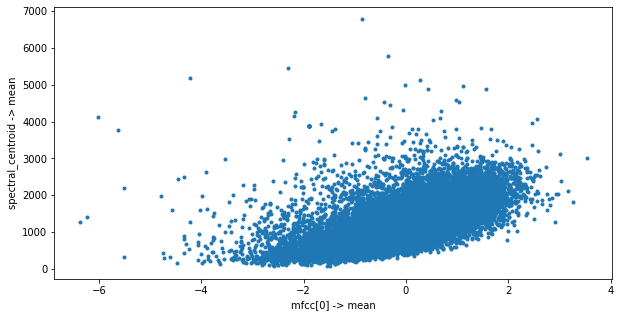

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], y, marker='.')
plt.xlabel('mfcc[0] -> mean')
plt.ylabel('spectral_centroid -> mean')
plt.show()

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

scoring_funcs_ = [lambda X, y: sklearn.metrics.explained_variance_score(X, y),
                 lambda X, y: sklearn.metrics.mean_absolute_error(X, y),
                 lambda X, y: sklearn.metrics.mean_squared_error(X, y)**0.5
                ]
scoring_funcs = [sklearn.metrics.make_scorer(fun) for fun in scoring_funcs_]
scoring_names=['explained variance score', 'mean absolute error', 'mean squared error']

scores = []
for reg in [LinearRegression(), Ridge(alpha=.5), Lasso(alpha=0.1), ElasticNet()]:
    scores_ = []
    for k in range(X.shape[-1]):
        reg.fit(X_train[:, 0:k+1], y_train)
        scores_.append(np.array([fun(reg, X_test[:, 0:k+1], y_test) for fun in scoring_funcs]))
    scores.append(np.stack(scores_))
scores = np.transpose(np.stack(scores), (2, 0, 1))

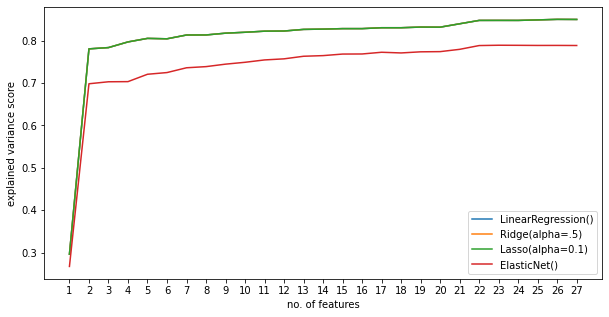

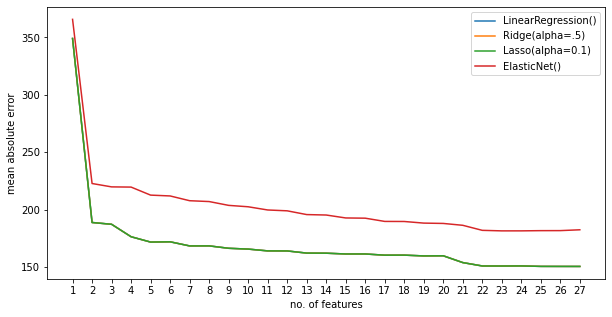

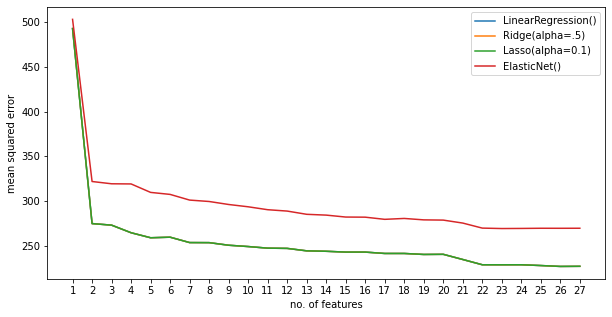

In [22]:
for i, metric_scores in enumerate(scores):
    plt.figure(figsize=(10, 5))
    for reg_score in metric_scores:
        plt.plot(range(1, len(reg_score)+1), reg_score)
        plt.xticks(range(1, len(reg_score)+1))
    plt.legend(['LinearRegression()', 'Ridge(alpha=.5)', 'Lasso(alpha=0.1)', 'ElasticNet()'])
    plt.ylabel(scoring_names[i])
    plt.xlabel('no. of features')
    plt.show()